## 通し課題　課題①Kickstarter Projects

### ★やること
### 1.目的変数と説明変数の関係を確認するためのグラフを作成する（ここからはNotebook上の作業です）
### 2.目的変数を説明するのに有効そうな説明変数を見つける
### 3. DAY1で学んだアルゴリズムを利用する
###### 　• 回帰の場合は線形回帰、分類の場合はロジスティック回帰
###### 　• 質的変数が扱えないアルゴリズムを使う場合は、ダミー変数に置き換える
### 4. 予測精度または識別精度を確認する
###### 　• 回帰問題の場合は、MSE、RMSE、MAEを求める
###### 　• 分類問題の場合は、混同行列を作成し、Accuracy、Recall、Precisionを求める
### 5. できたところまでをNotebookでまとめ、GithubまたはGistで公開する
###### 　• 公開方法がわからない方は、ipynbファイルを所属チャンネルに貼る
######    ⇒　英語の説明文は余裕があったら追記すること

In [4]:
%matplotlib inline
import os
import codecs
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

## ※※　グラフ作成のための前処理が必要
#### 　・今回は問題を簡単にするため、失敗（failed）と成功（successful）の分類とする（※他の項目は削除する）

### １ Read csv data

In [5]:
os.getcwd()

'C:\\Users\\KOBAYASHI\\Documents\\★ 【R2】AIゼミ基礎\\通し課題'

In [6]:
# ks-projects-201801.csv の読み込み
df_ksp = pd.read_csv("data/01 Kickstarter Projects/ks-projects-201801.csv")

##### 間違えて2016の方を読み込もうとしていた際の方法 orz　
##### codec errorが出たので、以下の方法をやってみて読み込むことができた。一応、参考まで。。。
- with codecs.open("data/01 Kickstarter Projects/ks-projects-201612.csv", 'r', 'utf-8', 'ignore') as f:
- df_ksp = pd.read_csv(f)

###### 　なお、2016の方はデータ長の異なるサンプルが複数あるため、煩雑な前処理が必要でした。。。

In [7]:
print(df_ksp.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


In [8]:
# とりあえずデータを表示
display(df_ksp.head())
#df_ksp.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [9]:
#欠損値の確認
print(df_ksp.index)

df_ksp.isnull().sum()

RangeIndex(start=0, stop=378661, step=1)


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

###### 　データ数：378660個
- 欠損値は少ない？nemeの欠損値は結果に影響しなさそうなので無視する。
- usd pledged（米ドル借入？）は、無しならゼロが入るので、欠損値をどうするか要検討（real付のデータから補間できる？）

In [10]:
#とりあえず”state”が”failed”か”successful”のデータを抽出する

df_temp = df_ksp[(df_ksp['state'] == 'failed')|(df_ksp['state'] =='successful')]
df_temp.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


### - 抽出後のデータ数は331675／378860

### 　２．カテゴリ変数をダミー変数に変換する
- 単純にすべての項目をダミー変数に置き換えようとするとメモリ不足になった。
- とりあえず使えそうな要素のみを置き換えてみることにする。
- stateは必須。countryやcurrencyは有用ではないか？
- categoryはできれば使いたいがメモリが足りるかわからない（やってみてダメそうなら諦める？）

In [11]:
# まずは state を failed = 0, successful = 1 へ変換する 
df_dummy = pd.get_dummies(df_temp['state'])

# ダミー変数行列を元の行列に追加
df_temp = pd.concat([df_temp, df_dummy], axis=1)

# 不要な列を削除（ここでは successful のみを残す）
df_temp = df_temp.drop(['state', 'failed'], axis=1)

# 分かりやすいように列名を変更する
df_temp = df_temp.rename(columns={'successful':'state'})
df_temp.head()

# [memo] ダミー変数行列の２列目を、元行列のstate列にコピー（代入）したらエラーが出た。回避方法がわからなかったので、上記の方法をとることとした。

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,US,100.0,2421.0,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.0,220.0,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.0,1.0,5000.00,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,US,52375.0,52375.0,50000.00,1


In [12]:
# 続いて country を変換してみる 
df_dummy = pd.get_dummies(df_temp['country'])
df_dummy.head()

,AT,AU,BE,CA,CH,DE,DK,ES,FR,GB,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
#23要素に分かれたので、これを元のフレームに加えてみる
# 参考：https://qiita.com/code0327/items/64cc12ca3f329922a3b5
df_temp = pd.concat([df_temp, df_dummy], axis=1)
df_temp = df_temp.drop('country', axis=1)
df_temp.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,...,0,0,0,0,0,0,0,0,0,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,...,0,0,0,0,0,0,0,0,0,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,...,0,0,0,0,0,0,0,0,0,1
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# 次に currency（通貨） を変換してみる 
df_dummy = pd.get_dummies(df_temp['currency'])
df_dummy.head()

,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
# こちらは14要素に分かれた。
df_temp = pd.concat([df_temp, df_dummy], axis=1)
df_temp = df_temp.drop('currency', axis=1)
df_temp.head()

,ID,name,category,main_category,deadline,goal,launched,pledged,backers,usd pledged,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,100.0,...,0,0,0,0,0,0,0,0,0,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,220.0,...,0,0,0,0,0,0,0,0,0,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,1.0,...,0,0,0,0,0,0,0,0,0,1
5,1000014025,Monarch Espresso Bar,Restaurants,Food,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,52375.0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# 同様に category を変換してみる
df_dummy = pd.get_dummies(df_temp['category'])
df_dummy.head()

,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,Architecture,...,Wearables,Weaving,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# 全159要素　⇒　多すぎるので、stateとの関連性をみてみる
df_temp2 = df_temp[['state']]
df_temp2 = pd.concat([df_temp2, df_dummy], axis=1)

# 相関係数を確認
#df_temp2.corr().head()

- いくつか相関性の高い項目があった（tabletop games etc.）
- 評価に含めたほうがよい結果がでそう？だが、データ点数が多くなりすぎる？

In [18]:
#とりあえず表に加えてみる
df_temp = pd.concat([df_temp, df_dummy], axis=1)
df_temp = df_temp.drop('category', axis=1)
df_temp.head()

,ID,name,main_category,deadline,goal,launched,pledged,backers,usd pledged,usd_pledged_real,...,Wearables,Weaving,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,100.0,2421.0,...,0,0,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Film & Video,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,220.0,220.0,...,0,0,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
5,1000014025,Monarch Espresso Bar,Food,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,52375.0,52375.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_temp.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state,AT,AU,...,Wearables,Weaving,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,1.074271e+09,4.425157e+04,1.058400e+04,116.381581,7.684569e+03,9.943461e+03,4.151000e+04,0.403877,0.001462,0.019947,...,0.002916,0.000247,0.012992,0.001806,0.015521,0.003190,0.000446,0.005849,0.002141,0.001070
std,6.191924e+08,1.117917e+06,1.015917e+05,965.427268,8.320938e+04,9.673293e+04,1.108930e+06,0.490674,0.038212,0.139819,...,0.053917,0.015722,0.113238,0.042459,0.123614,0.056389,0.021119,0.076256,0.046218,0.032698
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.371725e+08,2.000000e+03,5.000000e+01,2.000000,2.500000e+01,5.000000e+01,2.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.074573e+09,5.000000e+03,7.820000e+02,15.000000,5.020000e+02,7.880000e+02,5.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.609844e+09,1.500000e+04,4.657000e+03,63.000000,3.421000e+03,4.608000e+03,1.500000e+04,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### ３．グラフを書いてみる

- 今回は時間もないので、簡単なデータのみでやってみる
- 今回使用する変数は goal, backers, state の３項目とする
##### 　　⇒　pledged, usd_pledged, usd_pledged_real は目的変数とほぼほぼイコールなので、外す必要がある
##### 　　⇒　 usd_goal_real 余り意味がなさそう？今回は外してみる。

##### 今回は使わなかったもの　数値データの列のみに絞る(Ref. https://qiita.com/ryo111/items/bf24c8cf508ad90cfe2e)

In [29]:
# テーブルの整理
df_LR = df_temp[['goal', 'backers', 'state']]
df_LR.head()

,goal,backers,state
0,1000.0,0,0
1,30000.0,15,0
2,45000.0,3,0
3,5000.0,1,0
5,50000.0,224,1


             goal   backers     state
goal     1.000000  0.004794 -0.025099
backers  0.004794  1.000000  0.125790
state   -0.025099  0.125790  1.000000


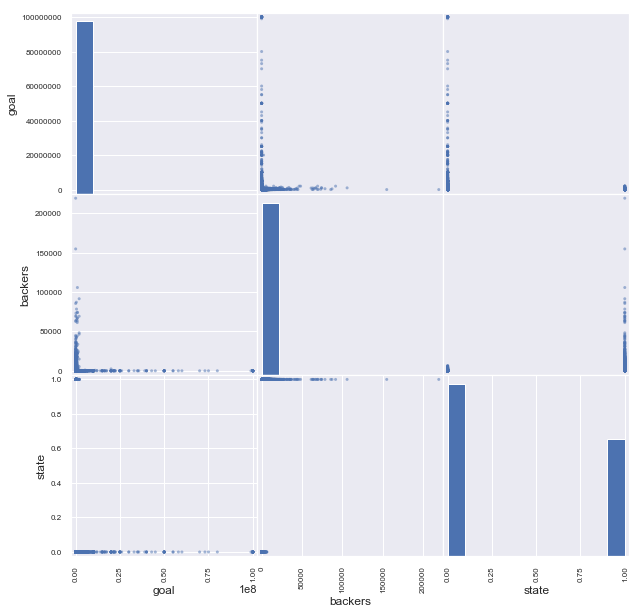

In [30]:
# 相関係数を確認
print(df_LR.corr())

# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df_LR, figsize=(10,10))
plt.show()

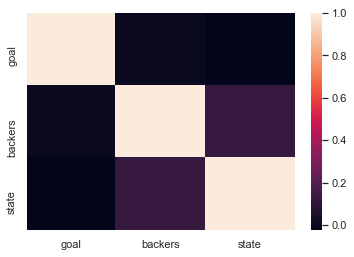

In [31]:
# ヒートマップを描画
sns.heatmap(df_LR.corr())
plt.show()

### ４．ロジスティック回帰

In [32]:
# 事前に successful の数をチェックする
df_check = df_LR['state']
print((df_check == 1).sum())

133956


In [34]:
# DAY1_6を参考にロジスティック回帰を記述
y = df_LR["state"].values
X = df_LR.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))

w0 = 2524.890, w1 = -7720.464, w2 = 1960175.557


In [38]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

対数尤度 = -3.999


In [36]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,164179,33540
正解 = 成功,4866,129090


In [37]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 88.421%
適合率（Precision） = 79.376%
再現率（Recall） = 96.367%
F1値（F1-score） = 87.051%


- ここで時間切れ。

### 10/4時点のメモ
- 時間的な問題もあるため、一旦 name, category, main_category のデータは使わずにやってみる
- 年月日時データ deadline, launched は有用なデータと思われるが、別途、数値データに置き換える必要があるので、やり方についてもう少し調べてからやってみることとする。
- グラフ（散布図）の処理が終わらない？エラーは出ていないため計算能力の問題か？　⇒　いったん描画なしで進めてみる
- ヒートマップを描画してみたが、stateと相関係数の高いものはなさそう。　⇒　年月日情報やカテゴリ情報がないことが影響か？

### 10/5時点のメモ
- deadline, launched の処理方法を考えて実装を試みたが、処理が重すぎたので一時中断する。

### 10/6時点のメモ
- 始めに説明変数に pledged 他を含めてしまったので、やたら正答率が高かった。
- 精度を上げるには説明変数を増やさないといけない。（締め切りまでの期間、各種カテゴリーデータ）

- 次に deadline（年月日）と launched（年月日時分秒）を数値的な指標に置き換える。
- 公開から終了までの日数で定義してみる。

##### ⇒　datetime型の変換に時間が掛かる（４時間で1/10程度？）ため、以下の処理は一時断念する。

In [28]:
# deadline & launched を抽出
df_temp2 = df_temp[['deadline', 'launched']]
df_temp2.insert(0, 'term', 0)
#print(df_temp2.head())

# deadline のデータを datetime型 に変換していく
# 参考　https://teratail.com/questions/192483
for count in range(0,len(df_temp2)):
    string_date_1 = df_temp2.iloc[count,1]
    d1 = datetime.datetime.strptime(string_date_1, '%Y-%m-%d') 
    string_date_2 = df_temp2.iloc[count,2]
    d2 = datetime.datetime.strptime(string_date_2, '%Y-%m-%d %H:%M:%S') 
    df_temp2.iloc[count,0] = (d1.date()-d2.date()).days
    #print(count)

# 元データテーブルへの結合
df_temp2 = df_temp2.drop(['deadline', 'launched'], axis=1)
df_temp = pd.concat([df_temp, df_temp2], axis=1)
df_temp.head() 

C:\Users\KOBAYASHI\Anaconda3\envs\AIsemi_basic_2020\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


KeyboardInterrupt: 

In [ ]:
#グラフを作る
# ig = plt.figure(figsize=(14,9))
#for i in np.arange(30):  #30が最大
#    ax = fig.add_subplot(5,6,i+1)
#    sns.regplot(x=df_n.iloc[:,i], y=df_n.state)

#グラフを整えて表示
#plt.tight_layout()
#plt.show()